# Testing the denoising performance of the CNN models
In this notebook, I will evaluate the denoising performance of the two neural network models I have trained. I will use a continuous time-series to simulate a real fluorescence recording and add recorded noise as per the training notebook. My goal is to determine if denoising the signal improves the recovery of ground truth acetylcholine (ACh) dynamics.

The processing pipeline is schematized below. It starts with the fitting of the fluorescence signal with spectral features related to ACh as well as known confounding factors (hemodynamics and movement-related artifacts). That enables the extraction of ACh dynamics and may be followed by either spectral smoothing or denoising by the CNN model. Next, the ACh signal is deconvolved to extract ACh release events underlying fluorescence changes. 

The goal is then to compare how well different pipelines (applying Gaussian smoothing, CNN denoising or none) recover ground truth ACh release events.

<img src="http://drive.google.com/uc?export=view&id=1X_85L9zPWdyiAwA_bmh56Tymr85QXXQ3" with="800" />

In [1]:
import sys
sys.path.append('../..')

In [2]:
from DeepDenoise.utils import deconv
from  DeepDenoise.utils import spectralfits
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

## Load test data
For these tests, I am using a testset that consists in a continuous time-series of synthetic biological signals with added noise. Noise has the largest magnitude used during neural network training. Note that the data is stored in a local server not publicly accessible.

In [3]:
# Load test timeseries
data = loadmat('../data/test_spect_all_noiseshot08.mat')
spect = data['spectest_full']   # With added noise
spect_clean = data['spectest']  # Without added noise

# Spectral features to be used in fittings
data_fits = loadmat('../data/noise_components_dataset_slowHb.mat')
ACh_spec = data_fits['ACh_spectrum']  # ACh spectrum
HbO2_spec = data_fits['OxyHb_absorption']   # HbO2 spectrum
Hb_spec = data_fits['Hb_absorption']    # Hb spectrum

## Denoise
The first step in the denoising pipeline is to denoise the signal using the trained CNNs. I will test the performance of CNNs trained with different noise levels, denoted "ns03" or "ns08" in the naming scheme, given that a noise scaling factor of 0.3 or 0.8 on the original noise was used for training, respectively. Note that the path where denoised recordings are saved is not publicly available.

In [4]:
# denoise using selected models
model_names = ['DnCNN_absoluteF_depth20_ns03_700','DnCNN_absoluteF_depth20_ns08_700']
denoised = []

for i,model in enumerate(model_names):
    denoised_path = f"/storage/ricardo/data/Project/Denoising/denoised/denoised{i}.mat"
    model_path = f"../models/depth20/{model}.pth"
    denoised.append(spectralfits.denoise(spect,model_path,denoised_path,network_depth=20,save_file=True))

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [4]:
# load if denoised data has already been saved
denoised = []
for i in range(2):
    denoised_tm = loadmat(f"/storage/ricardo/data/Project/Denoising/denoised/denoised{i}.mat")
    denoised.append(denoised_tm['data'])

## Smooth
In the smoothing pipeline, a commonly used 2D gaussian smoothing will be applied. I initially chose 3 levels of smoothing, with sigmas of 0.5, 0.6 and 1.

In [5]:
#Smooth with a gaussian kernel
from scipy.ndimage import gaussian_filter
sigmas = [0.5,0.6,1]
smooth = []
for sigma in sigmas:
    smooth.append(gaussian_filter(spect, sigma=sigma))

## Fit
The next step is the spectral fitting of the fluorescence data to extract ACh dynamics. The fitting function fits ACh spectral features together with other common components found in vivo, such as hemoglobin absorption and movement artifacts (modelled as wavelength-independent offsets, check function code for details).

In [7]:
# Make list with signals to fit
spect_list = [spect_clean,spect,smooth[0],smooth[1],smooth[2],denoised[0],denoised[1]]
# Define signal names
# Denoised 1: CNN trained with noise scalling=0.3 
# Denoised 2: CNN trained with noise scalling=0.8 
signal_names = ['Ground truth','Raw','Smooth 0.5','Smooth 0.6','Smooth 1','Denoised 1','Denoised 2']

In [ ]:
# Fit spectral features
fit_ACh = []
for spectra in spect_list:
    fit_tm = spectralfits.fit_ACh_spectra(spectra,ACh_spec,Hb_spec,HbO2_spec)
    fit_ACh.append(fit_tm[:,3])

#save if necessary
np.save('fit_ACh.npy',fit_ACh)

In [8]:
# Load fits if already available
fits = np.load('fit_ACh.npy')
fit_ACh = {}
#convert to dictionary
for name,fit in zip(signal_names,fits):
    fit_ACh[name] = fit

del fits

## Dynamics of acetylcholine across brain states

During the day, mice go through 4 main brain states: active wake (WK), quiet wake (QW), non-REM sleep (NREM) and REM sleep (REM). Acetylcholine plays a key role in memory encoding and sensory processing. Its extracellular concentration in the hippocampus (location of the measurements) is known to be highest during WK and REM.
The ground-truth ACh dynamics, obtained from an in vivo recording, reflects fast phasic ACh fluctuations as well as slow state-dependent dynamics (Figure below).

### Remove baseline during NREM sleep
The extracted ACh level is a relative measure, meaning that the absolute values are unknown. Given that the deconvolution algorithm requires intensities proportional to absolute ACh level, an estimation of ACh zero level is required. To achieve that, I make an approximation assuming that the lowest intensity recorded during NREM sleep is zero. Then I subtract that baseline value.

In [9]:
# Load Matlab array containing periods of different brain states for the time-series
data_states = loadmat('/storage/ricardo/data/Freely_moving/Processed/States/ZY0719/20191016c/states.mat')
NREM = data_states['states']['NREM'][0][0]  # Get NREM periods (defined by start and end times per row)
# Get the indices in the time-series located during NREM periods
SampRate = 5  # Sampling rate
indrA,_ = spectralfits.get_elements_in_periods(NREM*SampRate,np.arange(0,len(fit_ACh['Ground truth'])))

# Perform baseline subtraction
for name,signal in fit_ACh.items():
    # First low-pass filter to get a smooth signal
    AChfilt = spectralfits.ButFilter(signal,2,[0.2/(5/2)],'low').reshape(-1,1)
    # Get the minimum value during NREM
    min_NREM = np.min(AChfilt[indrA])
    fit_ACh[name] = fit_ACh[name]-min_NREM

Segment of baseline-subtracted ACh dynamics across brain states

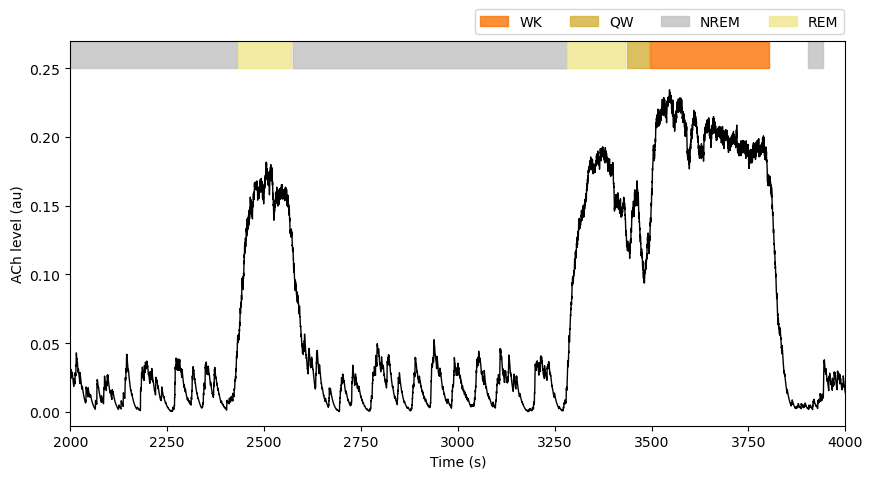

In [13]:
import matplotlib.patches as mpatches

#get the other states
WK = data_states['states']['WK'][0][0]
QW = data_states['states']['QW'][0][0]
REM = data_states['states']['REM'][0][0]

state_names = ['WK','QW','NREM','REM']

#Define colors for each state
state_colors = {
    "WK": "xkcd:orange",
    "QW": "#D4AF37",
    "NREM": "silver",
    "REM": "khaki"
}

# Create figure
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(len(fit_ACh['Ground truth']))/SampRate,fit_ACh['Ground truth'],color='black',linewidth=1)

# Draw state shades
for state_name in state_names:
    st = data_states['states'][state_name][0][0]
    color = state_colors[state_name]
    for period in st:
        ax.fill_between(np.arange(period[0],period[1]),0.27,0.25,alpha=0.8,color=color)

# Create custom legend elements
legend_elements = []
for state, color in state_colors.items():
    legend_elements.append(mpatches.Patch(color=color, label=state, alpha=0.8))

# Add legend with custom elements above the figure
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.76, 1.1),ncol=4)

ax.set(xlabel='Time (s)', ylabel='ACh level (au)')
plt.xlim(2000,4000)
plt.ylim(-0.01,0.27)
plt.show()

Notably, besides the large state-dependent changes, ACh shows fast fluctuations during every brain state (note that periods without unequivocal state classification were left as white spaces on the top shaded boxes).
The figure below shows a zoom-in on the ACh dynamics obtained with different pipelines during a NREM period. The most the signal traces follow the ground-thuth the better.

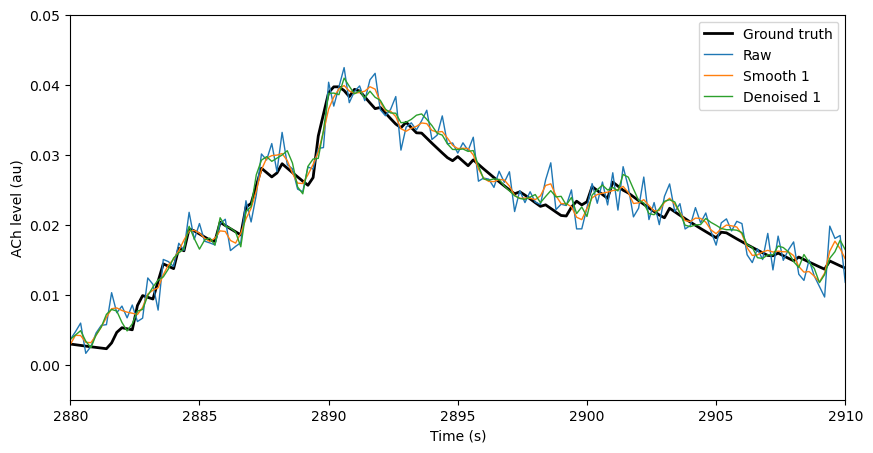

In [16]:
# Define subset of signals to plot
select_names = ['Ground truth','Raw','Smooth 1','Denoised 1']

# Create figure
fig, ax = plt.subplots(figsize=(10,5))

#plot signals
for name in select_names:
    if name=='Ground truth':
        ax.plot(np.arange(len(fit_ACh[name]))/5,fit_ACh[name],linewidth=2,color='black')
    else:
        ax.plot(np.arange(len(fit_ACh[name]))/5,fit_ACh[name],linewidth=1)

ax.set(xlabel='Time (s)', ylabel='ACh level (au)')
plt.xlim(2880,2910)
plt.ylim(-0.005,0.05)
ax.legend(select_names)
plt.show()

As expected the signal obtained when no signal cleaning is performed before the fitting step gives the noisiest ACh trace ('Raw'). Apparently, ACh dynamics after smoothed and denoising don't differ much. Let's have a look at the spectral data before the fitting step.

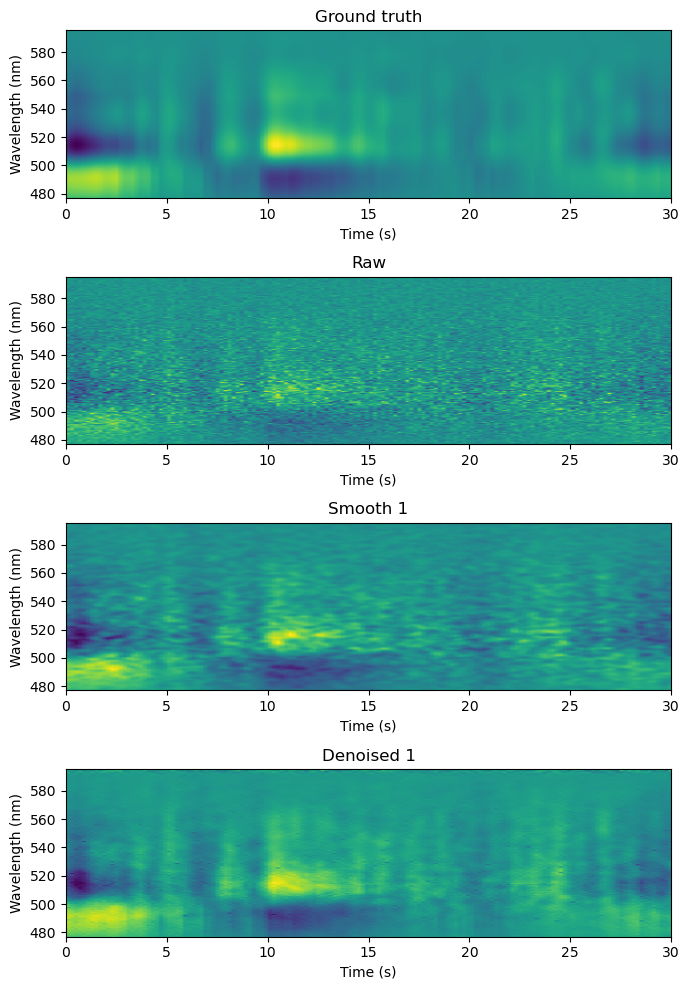

In [15]:
#Make dictionary of spectral data to plot
spect_dict = {}
for name,sp in zip(signal_names,spect_list):
    spect_dict[name] = sp

# Plot segment of spectral data
wavelength = [476.924,595.404]  # Wavelength axis
axis_lims = (0,30,wavelength[0],wavelength[1])

# Normalization function
def FNormalize(data):
    mean_data = np.mean(data,axis=0,keepdims=True)
    return data-mean_data

# Create figure
fig, ax = plt.subplots(4,1,figsize=(7,10))
limits = [2880*SampRate,2910*SampRate]
len_seg = limits[1]-limits[0]

#plot signals
for i,name in enumerate(select_names):
    ax[i].imshow(np.flipud(FNormalize(spect_dict[name][limits[0]:limits[1],:]).T),aspect='auto',extent=axis_lims)
    ax[i].set(xlabel='Time (s)', ylabel='Wavelength (nm)',title=name)
    
plt.tight_layout()
plt.show()

In this figure, denoised data ('Denoised 1') looks less noisy and sharper than the other processed signals. These sharp step-like changes in fluorescence, possibly stemming from discrete ACh release events, are particularly visible in the 'Ground truth' and 'Denoised 1' plots.

## Deconvolve signals
Fluorescence reporters commonly suffer from slow decay time constants, which distorts the true neuromodulator release dynamics. In order to capture the ACh release events underlying the recorded convolved ACh dynamics, we need to perform a deconvolution. Notably, applying a deconvolution algorithm that assumes a constant exponential decay (estimated from the data) returns good fits to the data.

The goal of the following tests is to characterize how well the different pipelines can reproduce ground truth ACh release events when noise is added to the spectral data. 

In [9]:
# Deconvolve signals
convfit = {}  # Convolution model fitting
deconv_signals = {}  # Deconvoluted signal to get ACh release events

for name,signal in fit_ACh.items():
    # ACh dynamics is deconvolved using a previously estimated decay time constant g
    g = 0.9791
    baseline = 0
    convfit_tm, deconvol_tm = deconv.deconvolveCa_py(signal,g,baseline)
    convfit[name] = convfit_tm
    deconv_signals[name] = deconvol_tm

## Coherence with ground truth
First I will compute a general metric to check how well each processed signal correlates with ground truth. Given that neuromodulator release occurs at multiple time scales I will characterize the spectral power and coherence with ground truth in the frequency domain. 

In [10]:
# Load spectral connectivity package
from spectral_connectivity import Multitaper,Connectivity

In [11]:
# Compute the power of the signals before deconvolution
ct = Multitaper(time_series=np.column_stack([fit_ACh[name] for name in fit_ACh]), 
                sampling_frequency=5,
                time_halfbandwidth_product=5,
                time_window_duration=32,
                time_window_step=16)

connect = Connectivity.from_multitaper(ct,expectation_type='time_trials_tapers',blocks=1)
power = connect.power()

# Compute coherence between signals and ground truth after deconvolution
ct = Multitaper(time_series=np.column_stack([deconv_signals[name] for name in deconv_signals]), 
                sampling_frequency=5,
                time_halfbandwidth_product=5,
                time_window_duration=32,
                time_window_step=16)

connect = Connectivity.from_multitaper(ct,expectation_type='time_trials_tapers',blocks=1)
coher = connect.coherence_magnitude()

### Power spectral density (PSD)

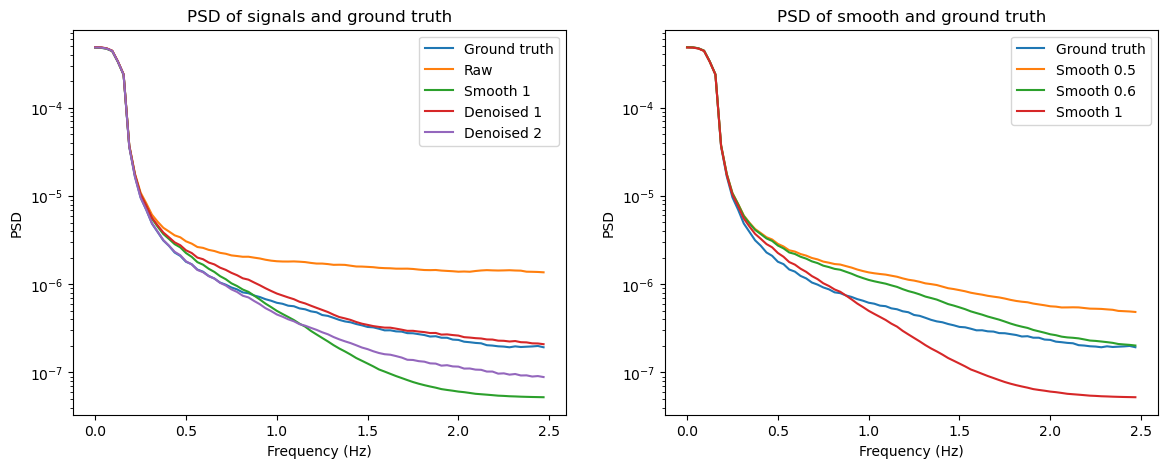

In [12]:
# Plot power spectra
select_ind = [0,1,4,5,6]  #indices of selected signals to plot
fig,ax = plt.subplots(1,2,figsize=(14,5))
for i in select_ind:
    ax[0].semilogy(connect.frequencies,power[:,i].squeeze())
ax[0].set(xlabel='Frequency (Hz)',ylabel='PSD',title='PSD of signals and ground truth',label=[signal_names[i] for i in select_ind])
ax[0].legend([signal_names[i] for i in select_ind])

#then for different smoothing sigmas
select_ind = [0,2,3,4]  #indices of selected signals to plot
for i in select_ind:
    ax[1].semilogy(connect.frequencies,power[:,i].squeeze())
ax[1].set(xlabel='Frequency (Hz)',ylabel='PSD',title='PSD of smooth and ground truth',label=[signal_names[i] for i in select_ind])
ax[1].legend([signal_names[i] for i in select_ind])

plt.show()

From the left panel, it is clear that the 'Raw' signal (without any cleaning step) is the most noisy, as it shows the highest power across all frequencies. The 'Deniosed 1' signal (from the pipeline in which the CNN trained with less noise was employed to denoise) shows a PSD somewhat similar to the ground truth. Interestingly, denoising with the CNN trained with the highest noise ('Denoised 2') results in excessive cancellation of the signal at high frequencies (> 1 Hz). This effect is even stronger when smooting with sigma = 1 is applied ('Smooth 1').
As expected, changing the extent of smoothing (by changing sigma) results in different PSD magnitudes. A sigma of 0.6 gives a PSD close to the ground truth and therefore was chosen for the following analysis.

### Coherence

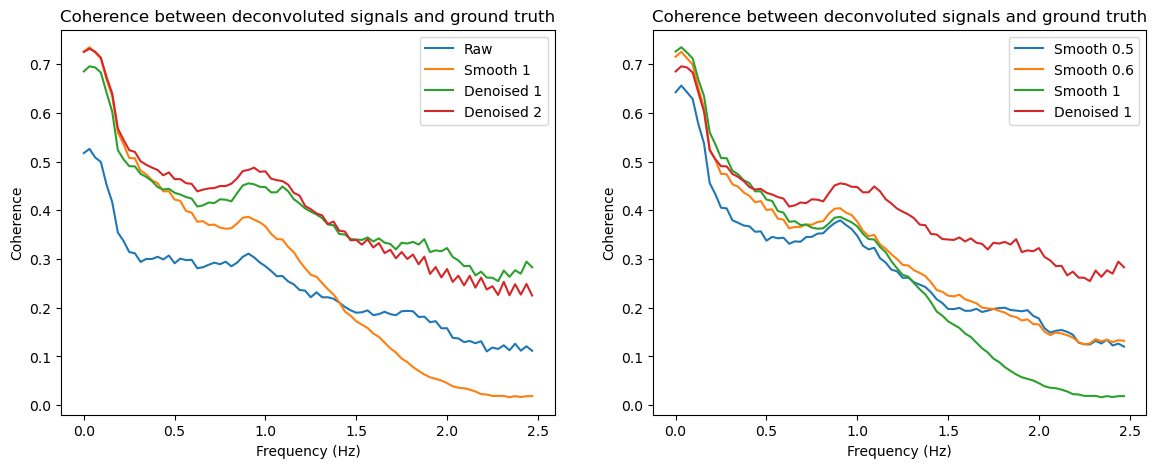

In [17]:
# Plot coherence
select_ind = [1,4,5,6]  #indices of signals to plot
fig,ax = plt.subplots(1,2,figsize=(14,5))
for i in select_ind:
    ax[0].plot(connect.frequencies,coher[:,0,i].squeeze())
ax[0].set(xlabel='Frequency (Hz)',ylabel='Coherence',title='Coherence between deconvoluted signals and ground truth',label=[signal_names[i] for i in select_ind])
ax[0].legend([signal_names[i] for i in select_ind])

#then for different smoothing sigmas
select_ind = [2,3,4,5]
for i in select_ind:
    ax[1].plot(connect.frequencies,coher[:,0,i].squeeze())
ax[1].set(xlabel='Frequency (Hz)',ylabel='Coherence',title='Coherence between deconvoluted signals and ground truth',label=[signal_names[i] for i in select_ind])
ax[1].legend([signal_names[i] for i in select_ind])

The left panel shows that the 'Raw' signal is the less coherent with ground truth overall. The outputs using CNN denoising give similar results well above the 'Raw-ground truth' coherence. The 'Smooth 1' signal returns a poor coherence specially in the high frequency range, which is explained by excessive signal cancellation. Remarkably, changing the extent of smoothing does not improve coherence above 'Raw-ground truth' (right panel). This applies even when using a sigma = 0.6 that gives a power magnitude resembling the ground truth.

The results suggest that the trained CNN denoising models surpass typically used smoothing approaches and, notably, the improved coherence with ground truth cannot be explained simply by a fine-tuning of signal cancellation extent. These observations rather suggest that the CNN models are selectively cancelling noise vs. true ACh dynamics. 

## Detect peaks in deconvolved signals
Following signal coherence analysis, it is important to get some insights into the factors underlying the better performance of CNN denoising models on that metric. Fot that goal, I will explicitly detect ACh release events as peaks in the deconvolved ACh time-series. I will analyse multiple parameters of the detected peaks, related to timing and amplitude. The goal is to compare how different pipelines perform in recovering the ground truth ACh release events.

In [65]:
# Import peak analysis functions from Scipy
from scipy.signal import find_peaks, peak_prominences

In [67]:
#select the signals that we want to further analyse
select_names = ['Ground truth','Raw', 'Smooth 0.6', 'Denoised 1', 'Denoised 2']

#find peaks in each signal
peaks_deconv = []
amps_deconv = []
prominence_deconv = []
trise_deconv = []

# Define period to analyse excluding the first and last 100 samples 
period = np.column_stack([100, len(deconv_signals['Ground truth'])-100])

for name in select_names:
    signal = deconv_signals[name]
    peaks, _ = find_peaks(signal.squeeze(),height=0)  # Detect all positive peaks
    # Pick only the events inside the defined period
    peaks,_ = spectralfits.get_elements_in_periods(period*SampRate,peaks)
    amp = signal[peaks]
    prom = peak_prominences(signal.squeeze(),peaks)[0]
    trise = np.zeros(len(peaks))
    #find zeros preceeded by zeros
    original_ind = np.flip(np.arange(len(signal)))
    fl_signal = np.flip(signal)

    zeros = np.where(fl_signal==0)[0]
    zeros_pre = np.where(np.diff(zeros)==1)[0]
    zeros_pre = zeros[zeros_pre]
    zeros_seq = original_ind[zeros_pre]

    for i,peak in enumerate(peaks):
        #find closest zero_seq preceeding peak
        zeros_diff = peak - zeros_seq
        #select only the zeros_seq with positive zeros_diff
        zeros_seq_pos = zeros_seq[zeros_diff>0]
        #find index of closest zero_seq_pos
        ind = np.argmin(np.abs(zeros_seq_pos-peak))
        #find index of zero_seq
        ind_zero = zeros_seq_pos[ind]
        #calculate trise
        trise[i] = peak-ind_zero
    
    peaks_deconv.append(peaks)
    amps_deconv.append(amp)
    prominence_deconv.append(prom)
    trise_deconv.append(trise)

## Amplitude and Trise
Let's first check the distributions of event amplitudes and rise times.

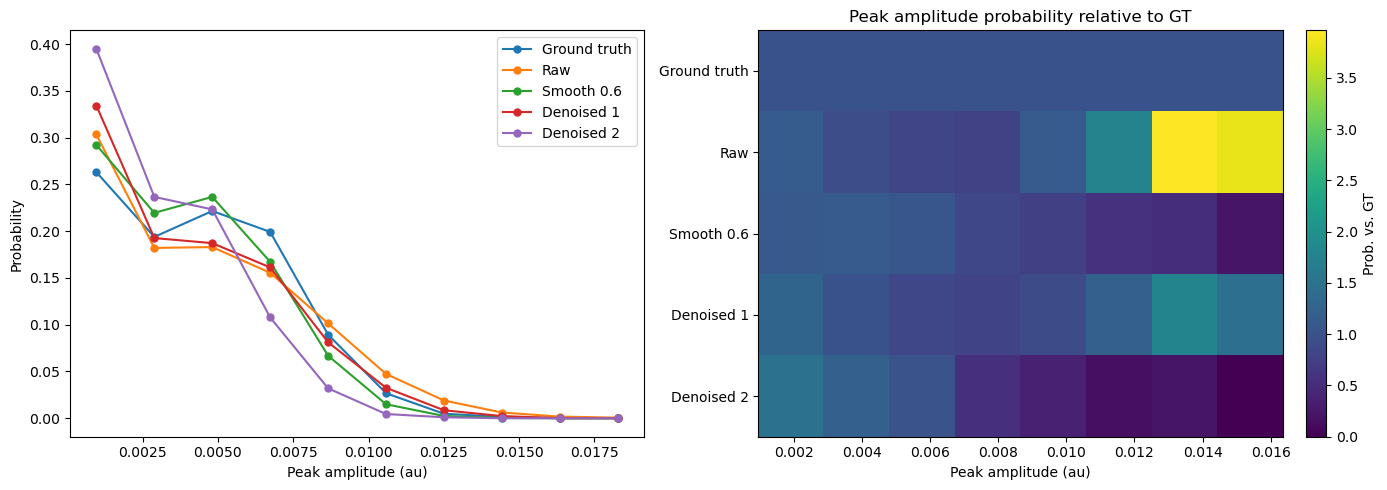

In [70]:
#histograms of amplitude of processed signals
hist_amp = []
#bins_amp = []
_,bins_amp = np.histogram(amps_deconv[1],bins=10)
bins_x = bins_amp[:-1] + np.diff(bins_amp)[0]/2

for i,amp in enumerate(amps_deconv):
    hist,bins = np.histogram(amp,bins=bins_amp)
    hist_amp.append(hist/len(amp))
    
# Create figure
fig,ax = plt.subplots(1,2,figsize=(14,5))

#plot histograms
for amp in hist_amp:
    ax[0].plot(bins_x,amp,marker='.',ms=10)

ax[0].set(xlabel='Peak amplitude (au)',ylabel='Probability',label=select_names)
ax[0].legend(select_names)

hist_data = np.column_stack(hist_amp)
implot = hist_data[:-2,:]/hist_data[:-2,0].reshape(-1,1)  #exclude the last 2 elements to avoid division by zero
cax = ax[1].imshow(implot.T,aspect='auto',extent=[bins_x[0],bins_x[-2],-0.5,len(select_names)-0.5])
ax[1].set(xlabel='Peak amplitude (au)',yticks=range(5),yticklabels=select_names[::-1],title='Peak amplitude probability relative to GT')
cbar = plt.colorbar(cax,fraction=0.046,pad=0.04)  #add colorbar
cbar.set_label('Prob. vs. GT')
plt.tight_layout()
plt.show()


The histograms above reveal two distinct patterns: the 'Raw' signal, which contains the highest noise level, tends to over-represent high event amplitudes whereas the 'Smooth' and 'Denoised 2' signals tend to under-represent the highest amplitude events. The latter effect is possible caused by over-cancellation of the true ACh release dynamics. The event amplitudes extracted from 'denoised 1' seem to more closely match the ground truth across the presented range.

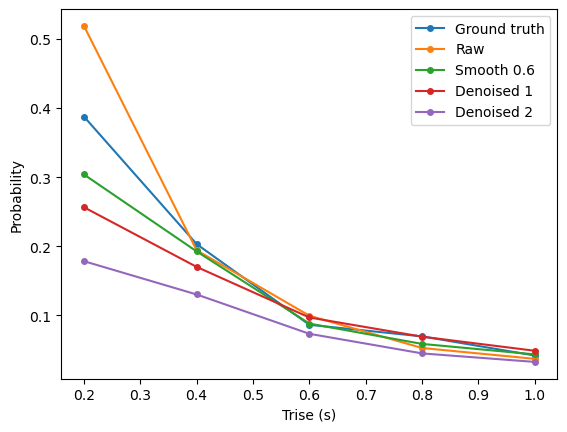

In [71]:
#histograms of Trise of processed signals
hist_trise = []
bins_trise = np.arange(0.5,6.5,1)/SampRate

for i,trise in enumerate(trise_deconv):
    hist,bins = np.histogram(trise/5,bins=bins_trise)
    hist_trise.append(hist/len(trise))

#plot histograms
for trise in hist_trise:
    plt.plot(bins_trise[:-1]+0.1,trise,marker='.',ms=8) 

plt.legend(select_names)
plt.xlabel('Trise (s)')
plt.ylabel('Probability')
plt.show()

Regarding the ACh release events' rise time, it is apparent that the probability of finding the sharpest events (Trise between 0.2 and 0.4 s) in 'Smooth 0.6' signal is the one that more closely matches the ground truth distribution. Contrarily to the 'Raw', the signals arising upon CNN denoising underestimate the sharpest events.

It is however important to have in mind that having amplitude and Trise distributions that match the ground truth does not actually imply any correlation with it. 
In the next sections I will directly check the relationship between amplitudes and timings of events.

## Amplitude relationships
First I will check the amplitude relationships between the ground truth and the other pipelines by plotting one against the other.

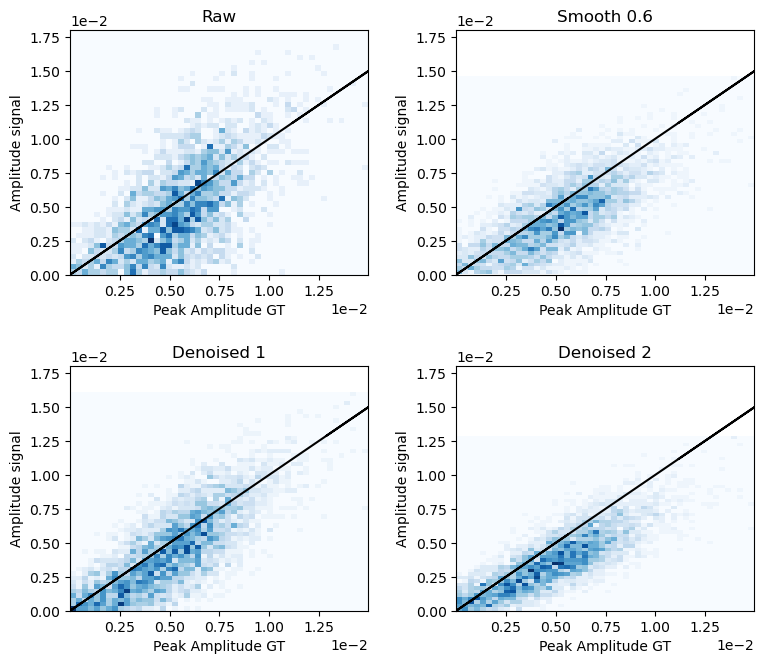

In [72]:
# Create figure
fig,ax = plt.subplots(2,2,figsize=(8,7))

for i,name in enumerate(select_names[1:]):
    amp_signal = deconv_signals[name][peaks_deconv[0]]
    
    #exclude very low amplitude events
    ind0 = (amp_signal>1e-6) & (amps_deconv[0]>1e-6)
    amp_signal = amp_signal[ind0]
    amp_gt = amps_deconv[0][ind0]
    
    #plot
    ax[i//2,i%2].hist2d(amp_gt,amp_signal,bins=50,cmap='Blues')
    ax[i//2,i%2].set(title=name,xlabel='Peak Amplitude GT',ylabel='Amplitude signal')
    ax[i//2,i%2].set_ylim((0,0.018))
    ax[i//2,i%2].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    ax[i//2,i%2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
    ax[i//2,i%2].plot(amp_gt,amp_gt,color='black')

plt.tight_layout(pad=2)
plt.show()

The main observation from these plots is that the amplitudes extracted from 'Denoised 1' better match the ground truth (black lines denote y=x). Next I will quantify this relationship by computing the ratio of event amplitudes vs. ground truth for the highest amplitude range(>0.0075).

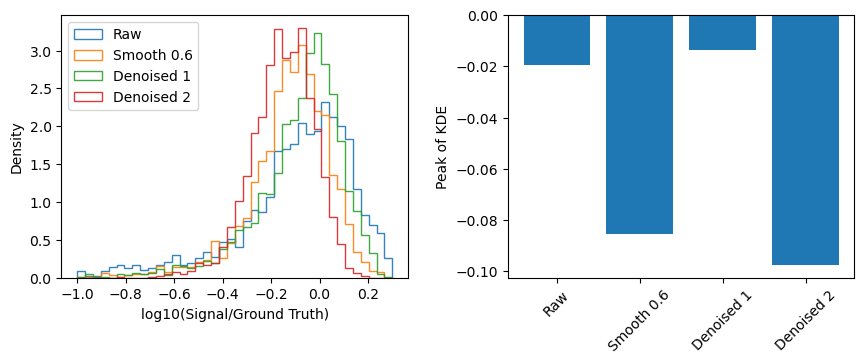

In [75]:
from scipy.stats import linregress

fig,ax = plt.subplots(1,2,figsize=(9,4))

high_ratio = []

for i,name in enumerate(select_names[1:]):
    amp_signal = deconv_signals[name][peaks_deconv[0]]
    ind0 = amp_signal>0
    amp_signal = amp_signal[ind0]
    amp_gt = amps_deconv[0][ind0]

    high_gt = amp_gt>=0.005
   
    hr = np.log10(amp_signal[high_gt]/amp_gt[high_gt])
    #hr = amp_signal[high_gt]/amp_gt[high_gt]
    ax[0].hist(hr,histtype='step',alpha=0.9,bins=40,range=(-1,0.3),density=True,label=name)

    #calculate mode using kernel density estimate
    kde = gaussian_kde(hr)
    x = np.linspace(-1,0.5,1000)
    #ax[1].plot(x,kde(x),label=name)

    high_ratio.append(x[np.argmax(kde(x))])

ax[0].set(xlabel='log10(Signal/Ground Truth)',ylabel='Density')
ax[0].legend(loc=2)

ax[1].bar(select_names[1:],high_ratio)
ax[1].tick_params(axis='x',rotation=45)
ax[1].set(ylabel='Peak of KDE')
plt.tight_layout(pad=2)
plt.show()
    


As suggested from the previous plots, the distribution of the amplitude ratios shows a peak closest to 1 (0 of the log10) for the 'Denoised 1' signal. These results suggest 'Denoised 1' is the pipeline leading to less distortion of ACh release amplitude.

## False negative and false positive rates in deconvolved signal peaks
To quantify how the different pipelines can faithfully reproduce ACh release timing I will compute false positive and false negative rates for the peak timings.

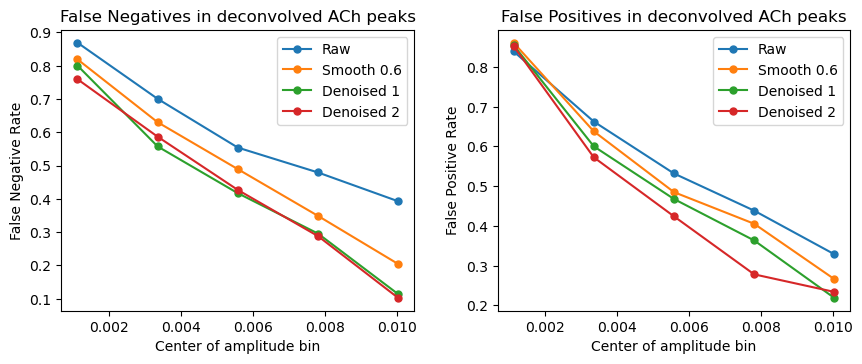

In [76]:
# Define amplitude bins to compute the metrics
# Create 5 bins between zero and percentile 99
bins_amp = np.arange(0,np.quantile(amps_deconv[0],0.99),np.quantile(amps_deconv[0],0.99)/5)
bins_amp = np.append(bins_amp,10)
bin_ind = np.digitize(amps_deconv[0],bins_amp)-1
bins_x = bins_amp[:-1]+np.diff(bins_amp)[0]/2  #center of the bins to plot

# False negatives
fns = np.zeros((len(select_names)-1,len(bins_amp)-1))

for peaks_ind,peaks in enumerate(peaks_deconv[1:]):
    #find false negatives
    for i in np.arange(0,len(bins_amp)-1):
        n_correct = len(np.intersect1d(peaks_deconv[0][bin_ind.squeeze()==i],peaks))
        fns[peaks_ind,i] = (sum(bin_ind==i)-n_correct)/sum(bin_ind==i)

# Plot
fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(bins_x,fns.T,marker='.',ms=10)
ax[0].set(xlabel='Center of amplitude bin',ylabel='False Negative Rate',title='False Negatives in deconvolved ACh peaks')
ax[0].legend(select_names[1:])

# False positives
fps = np.zeros((len(select_names)-1,len(bins_amp)-1))

for peaks_ind,peaks in enumerate(peaks_deconv[1:]):
    # Digitize
    bin_ind = (np.digitize(amps_deconv[peaks_ind+1],bins_amp)-1).squeeze()
    # Find false positives
    for i in np.arange(0,len(bins_amp)-1):
        n_correct = len(np.intersect1d(peaks[bin_ind==i],peaks_deconv[0]))
        fps[peaks_ind,i] = (sum(bin_ind==i)-n_correct)/sum(bin_ind==i)

ax[1].plot(bins_x,fps.T,marker='.',ms=10)
ax[1].set(xlabel='Center of amplitude bin',ylabel='False Positive Rate',title='False Positives in deconvolved ACh peaks')
ax[1].legend(select_names[1:])
plt.tight_layout(pad=2)
plt.show()


The results show that the CNN denoising pipeline yields fewer instances of both false positives and false negatives, thereby implying a superior precision in recovering the ground truth ACh release dynamics compared to the 'Smooth' or 'Raw' pipelines.

## Conclusion

The tests performed in this notebook support that denoising the fluorescence data prior to extraction of ACh dynamics improves the recovery of authentic changes in the neuromodulator level in vivo, compared with pipelines where a gaussian smoothing or no data cleaning is applied. 

Interestingly, the CNN model trained with the lowest noise level ('Denoise 1') offered overall better performance when compared with its counterpart ('Denoise 2'). Application of both CNNs led to comparable coherence with ground truth and similar false positive a false negative rates on ACh release events detection. However, release events extracted from the 'Denoise 2' signal showed substantially larger distortion of amplitudes and rise times than with 'Denoise 1'.